<a href="https://colab.research.google.com/github/kundajelab/feature_interactions/blob/master/zeropadding/InvestigatePositionalDependence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/kundajelab/feature_interactions/raw/6f96084/av/data/test_simulation.simdata.gz

--2020-06-26 06:48:29--  https://github.com/kundajelab/feature_interactions/raw/6f96084/av/data/test_simulation.simdata.gz
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/feature_interactions/6f96084022c0172d5d0fd1e4275a1669ec181db9/av/data/test_simulation.simdata.gz [following]
--2020-06-26 06:48:29--  https://raw.githubusercontent.com/kundajelab/feature_interactions/6f96084022c0172d5d0fd1e4275a1669ec181db9/av/data/test_simulation.simdata.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2103069 (2.0M) [application/octet-stream]
Saving to: ‘test_simulation.simdata.gz’

test_simulation.si

In [2]:
!gunzip test_simulation.simdata.gz

In [4]:
!pip install simdna
import simdna
from simdna import synthetic

test_data = synthetic.read_simdata_file("test_simulation.simdata")

     |████████████████████████████████| 634kB 8.0MB/s 
  ERROR: Failed building wheel for simdna
  Running setup.py clean for simdna
Failed to build simdna
    Running setup.py install for simdna ... done


In [11]:
import numpy as np
from collections import OrderedDict

def convert_pwm_to_deltadeltaG(pwm):
  deltadeltaG = -np.log(pwm/np.array([background_letter_freq[x]
                              for x in ['A', 'C', 'G', 'T']])[None,:])
  return deltadeltaG

background_letter_freq = OrderedDict(
    [('A', 0.27), ('C', 0.23), ('G', 0.23), ('T', 0.27)])
loadedMotifs = synthetic.LoadedEncodeMotifs(simdna.ENCODE_MOTIFS_PATH, pseudocountProb=0.001)
pwm_GATA_orig = loadedMotifs.loadedMotifs["GATA_disc1"].getRows()
pwm_TAL_orig = loadedMotifs.loadedMotifs["TAL1_known1"].getRows()
pwm_GATA = convert_pwm_to_deltadeltaG(pwm_GATA_orig)
pwm_TAL = convert_pwm_to_deltadeltaG(pwm_TAL_orig)

In [13]:
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1


def is_separation_valid(gata_start, tal_start):
  #separation_needed is the separation needed between
  # motifs so that there's no ground-truth interaction
  separation_needed = max(len(pwm_TAL), len(pwm_GATA))-1
  return ((gata_start-tal_start >= len(pwm_TAL)+separation_needed) or
          (tal_start-gata_start >= len(pwm_GATA)+separation_needed))


def sample_gata_and_tal_positions(seqlen, rng):
  while True:
    gata_start = rng.randint(0, (seqlen-len(pwm_GATA)+1))
    tal_start = rng.randint(0, (seqlen-len(pwm_TAL)+1))
    if is_separation_valid(gata_start=gata_start, tal_start=tal_start):
      return (gata_start, tal_start)


#functions copied from Generate_Data
def get_indices_and_motif_positions_to_analyze(embeddings_list, onehot_data):
  rng = np.random.RandomState(1234)
  #only consider sequences 
  toanalyze_info = []
  toanalyze_info_control = [] #also get random positions as a control
  for i in range(len(embeddings_list)):
    embeddings = embeddings_list[i]
    if (len(embeddings)==2):
      if embeddings[0].what.stringDescription=="GATA_disc1":
        assert embeddings[1].what.stringDescription=="TAL1_known1"
        gata_start = embeddings[0].startPos
        tal_start = embeddings[1].startPos
      else:
        assert embeddings[0].what.stringDescription=="TAL1_known1"
        assert embeddings[1].what.stringDescription=="GATA_disc1"
        gata_start = embeddings[1].startPos
        tal_start = embeddings[0].startPos
      if is_separation_valid(gata_start=gata_start, tal_start=tal_start):
        gata_onehot = onehot_data[i][gata_start:gata_start+len(pwm_GATA)]
        tal_onehot = onehot_data[i][tal_start:tal_start+len(pwm_TAL)]
        gata_score = np.sum(pwm_GATA*gata_onehot)
        tal_score = np.sum(pwm_TAL*tal_onehot)
        if (gata_score < -2 and tal_score < -2):
          toanalyze_info.append( (i, gata_start, tal_start) )
          
          #Get randomly sampled positions
          new_gata_start, new_tal_start = sample_gata_and_tal_positions(
              seqlen=len(onehot_data[i]), rng=rng)
          toanalyze_info_control.append( (i, new_gata_start, new_tal_start) )
  return toanalyze_info, toanalyze_info_control


test_data = synthetic.read_simdata_file("test_simulation.simdata")

test_toanalyze_info, controltest_toanalyze_info =\
  get_indices_and_motif_positions_to_analyze(
      embeddings_list=test_data.embeddings,
      onehot_data=test_onehot_data)

In [14]:
#load the prediction info of negative control models
!wget https://github.com/kundajelab/feature_interactions/raw/619bc75/av/model_preds.tgz
!tar -xzf model_preds.tgz model_preds

--2020-06-26 06:57:20--  https://github.com/kundajelab/feature_interactions/raw/619bc75/av/model_preds.tgz
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kundajelab/feature_interactions/619bc7523b287c1c3bb31ec19a5223feecb099ab/av/model_preds.tgz [following]
--2020-06-26 06:57:20--  https://raw.githubusercontent.com/kundajelab/feature_interactions/619bc7523b287c1c3bb31ec19a5223feecb099ab/av/model_preds.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47392316 (45M) [application/octet-stream]
Saving to: ‘model_preds.tgz’

model_preds.tgz     100%[===================>]  45.20M   138MB/s    in 0.3s  

In [36]:
from google.colab import drive
drive.mount('/content/drive')

!cp /content/drive/My\ Drive/colab_notebook_data/feature_interactions/model_preds_zeropadding/* model_preds
!ls model_preds

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
negcontrol_model-anscombemse_arch1_l1reg-0.0001_seed100_bemnn.h5
negcontrol_model-anscombemse_arch1_l1reg-0.0001_seed200_dmeaz.h5
negcontrol_model-anscombemse_arch1_l1reg-0.0001_seed300_vwlzj.h5
negcontrol_model-anscombemse_arch1_l1reg-0.0001_seed400_vyqvb.h5
negcontrol_model-anscombemse_arch1_l1reg-0.0001_seed500_msloc.h5
negcontrol_model-anscombemse_arch1_l1reg-0.001_seed100_tiefn.h5
negcontrol_model-anscombemse_arch1_l1reg-0.001_seed200_iwhrl.h5
negcontrol_

In [37]:
import glob

MODEL_PREDS_FOLDER = "model_preds"
negcontrol_modelpredsfiles_validpadding =\
  glob.glob(MODEL_PREDS_FOLDER+"/negcontrol_*_seed*.h5")
negcontrol_modelpredsfiles_samepadding =\
  glob.glob(MODEL_PREDS_FOLDER+"/negcontrol_*anscombemse*_seed*.h5")


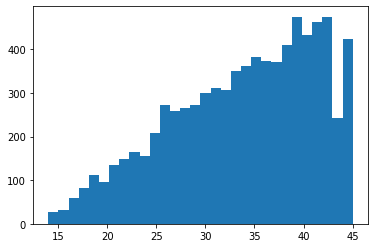

In [38]:
SEQLEN = len(test_data.sequences[0])
maxmotifdistfromcenter = np.array([
  max(abs(x[1]+0.5*len(pwm_GATA)-0.5*SEQLEN),
      abs(x[2]+0.5*len(pwm_TAL)-SEQLEN/2))
  for x in test_toanalyze_info])
from matplotlib import pyplot as plt
plt.hist(maxmotifdistfromcenter, bins=30)
plt.show()

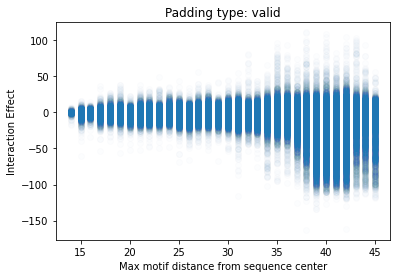

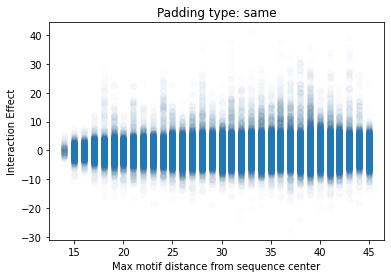

In [41]:
import h5py
from collections import namedtuple

InteractionEffectData = namedtuple("InteractionEffectData",
  ["orig_preds", "A_main_eff", "B_main_eff", "inter_eff", "maineff_preds"])

def get_interactioneffectdata(modelpredsfile, perturbedseqskey):
  model_h5 = h5py.File(modelpredsfile, "r")
  orig_preds = np.array(model_h5[perturbedseqskey]['orig_onehot_preds'])
  Aoff_preds = np.array(model_h5[perturbedseqskey]['Aoff_onehot_preds'])
  Boff_preds = np.array(model_h5[perturbedseqskey]['Boff_onehot_preds'])
  bothoff_preds = np.array(model_h5[perturbedseqskey]['bothoff_onehot_preds'])
  model_h5.close()

  A_main_eff = (Boff_preds - bothoff_preds)
  B_main_eff = (Aoff_preds - bothoff_preds)
  inter_eff = (orig_preds - bothoff_preds) - (A_main_eff + B_main_eff)
  maineff_preds = bothoff_preds + A_main_eff + B_main_eff

  return InteractionEffectData(orig_preds=orig_preds, A_main_eff=A_main_eff,
                               B_main_eff=B_main_eff, inter_eff=inter_eff,
                               maineff_preds=maineff_preds)

for (negcontrol_modelpredsfiles, paddingtype) in [
       (negcontrol_modelpredsfiles_validpadding, "valid"),
       (negcontrol_modelpredsfiles_samepadding, "same")]:
  scatter_xaxis = []
  scatter_yaxis = []
  for modelpredsfile in negcontrol_modelpredsfiles:
    #print(modelpredsfile)
    test_toanalyze_interactioneffectdata = get_interactioneffectdata(
          modelpredsfile=modelpredsfile,
          perturbedseqskey='test_toanalyze_perturbedseqs')
    scatter_xaxis.extend(maxmotifdistfromcenter)
    scatter_yaxis.extend(test_toanalyze_interactioneffectdata.inter_eff)
  #plt.scatter(maxmotifdistfromcenter,
  #            test_toanalyze_interactioneffectdata.inter_eff)

  plt.scatter(scatter_xaxis, scatter_yaxis, alpha=0.01)
  plt.title("Padding type: "+str(paddingtype))
  plt.ylabel("Interaction Effect")
  plt.xlabel("Max motif distance from sequence center")
  plt.show()